# Sorteo de causas aleatorio y evitando el desbalance

La idea es hacer un asignador de juzgado a las causas que se vayan presentando de modo tal que los juzgados estén balanceados de trabajo y no se pierda la aleatoriedad en la asiganción para que no se pueda saber previamente a dónde iría la causa. Para ello sería lógico usar una asignación aleatoria con una distribución de probabilidad uniforme pero esto tendría un par de inconvenientes. Primero, en nuestro caso los juzgados inician ya desbalanceados y es deseable que se balanceen con el tiempo. En segundo lugar, aunque empesaran balanceados, una distribución de probabilidad uniforme asegura un balanceo a tiempo infinito pero en tiempos cortos se pueden producir desbalances locales grandes. Entonces una buena opción es utilizar una asignación aleatoria pero con una distribución de probabilidad no uniforme en la cual tenga más probabilidad el juzgado que tenga actualmente menor carga de trabajo. De esta forma, si se comienza de una situación desbalanceada, tenderá a balancearse y además no se generarán grandes desbalances locales en el tiempo. Por otro lado, la asignación sigue siendo aleatoria y todos los juzgados tienen probabilidad no nula de ser seleccionados con lo cual se logra la transparencia esperada.

Para definir la carga de trabajo en este ejemplo usamos simplemente la cantidad de causas pero todo el desarrollo funcionaría de igual forma para cualquier indicador de carga de trabajo. Partimos de la distribución inicial de causas por juzgado, en este caso 31 juzgados con una diferencia de 100 causas máxima entre juzgados.

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def probabilidad(causas, alfa):
    njuz = len(causas)  
    
    # Probabilidad a asignar a cada juzgado
    P = 1.0/(causas-np.min(causas)+alfa)
    P = P/np.sum(P) # Para que la suma de P(j) = 1.0
    
    # Genera función para transformar de función uniforme a la que queremos
    X=np.zeros(njuz+1)
    Y=np.array(range(njuz+1))
    X[0]=0
    for ii in range(njuz):
        X[ii+1] = P[ii] + X[ii]
    return X, Y, P

causas =np.array(np.random.uniform(0,100,31)+300,int)     
X, Y, P = probabilidad(causas,5)

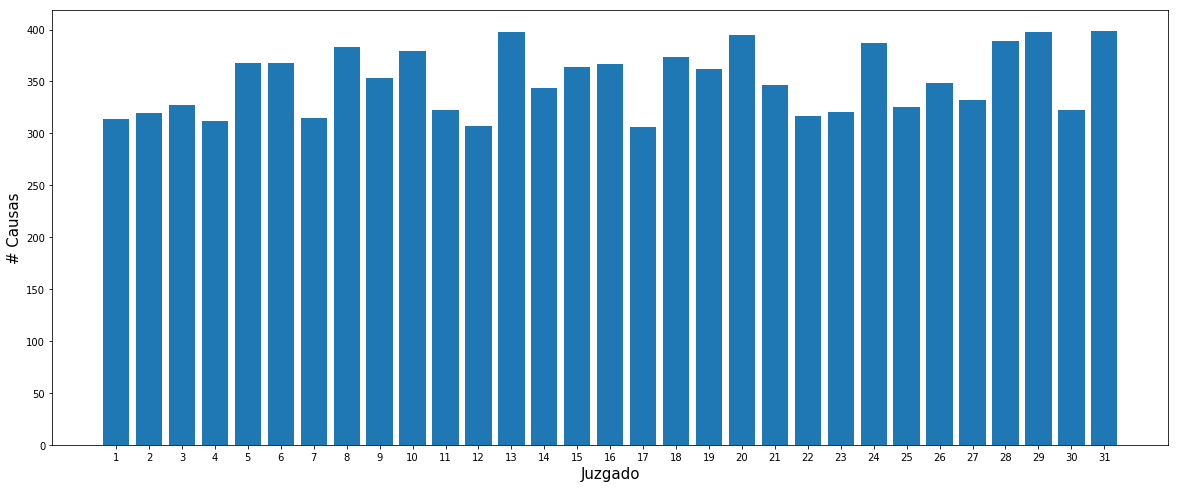

In [2]:
ifig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(31)+1.0
plt.bar(x,causas)
ax.set_xlabel('Juzgado', fontsize=15)
ax.set_ylabel('# Causas', fontsize=15)
x_ticks = ax.set_xticks(x)

Para esta distribución actual de causas se genera la distribucion de probabilidad con una probabilidad diferente para cada juzgado y funcion de la carga actual de trabajo. Con el parámetro alfa de la función anterior, se maneja cuanto peso se le da a la diferencia en la carga de trabajo. Si se coloca un valor chico de alfa, los juzgados que tengan menos carga de trabajo que el resto tendrán mucho más probabilidad de ser elegidos. Cuando el parámetro alfa se va aumentando, las diferencias de probabilidades van siendo menos abruptas. Podemos ver en el siguiente gráfico el valor de probabilidad de ser elegido para cada juzgado para el caso de alfa=5.

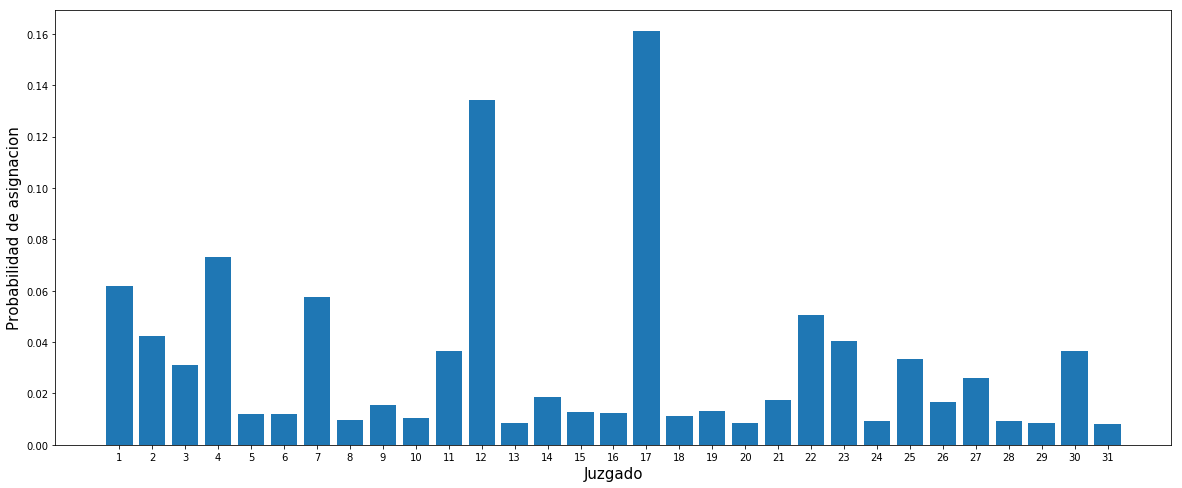

In [3]:
fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(31)+1.0
plt.bar(x,P)
ax.set_xlabel('Juzgado', fontsize=15)
ax.set_ylabel('Probabilidad de asignacion', fontsize=15)
x_ticks = ax.set_xticks(x)

Con la probabiidad definida, se genera la función para transformar de un numero aleatorio con distribución uniforme [0,1] a número de juzgado con la probabilidad definida anteriormente.

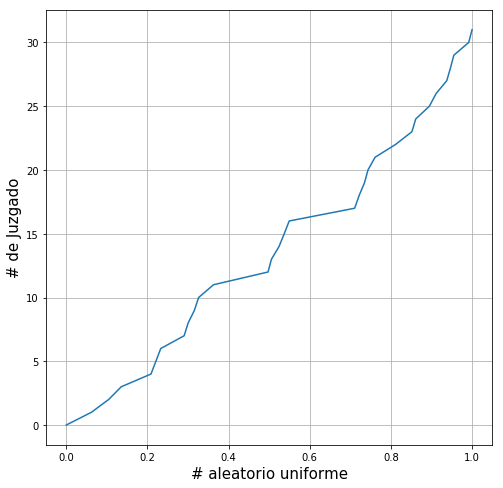

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(X,Y)
ax.set_xlabel('# aleatorio uniforme', fontsize=15)
ax.set_ylabel('# de Juzgado', fontsize=15)
plt.grid(True)

Ahora solamente resta tirar un numero aleatorio y con la función anterior se asignará el juzgado correspondiente. Una vez que se asigna una nueva causa, la cantidad de casos por juzgados cambia y entonces se debe recalcular la probabilidad por juzgado y la correspondiente función de transformación.
En el siguiente ejemplo se muestra una tirada de 4000 causas.

In [5]:
# numero random distribución uniforme
nc = 4000
s = np.random.uniform(0,1,nc)

# Entro con un numero aleatorio U[0,1] y sale con el número de juzgado
Desbalance=[] # Diferencia entre el juzgado que más causas tiene y el que menos
for ii in range(nc):
    X, Y, P = probabilidad(causas,5)
    JuzSorteado = np.int(griddata(X, Y, s[ii], method='linear'))
    causas[JuzSorteado] +=1
    Desbalance.append(np.max(causas)-np.min(causas))

Podemos ver en el siguiente gráfico cómo va disminuyendo el desbalance a medida que se asignan nuevas causa y una vez balanceado se mantiene. Definimos el indicador de desbalance cómo la diferencia entre el juzgado que más causas tiene y el que menos. Al querer que la distribución final sea uniforme, creo que este indicador es adecuado.

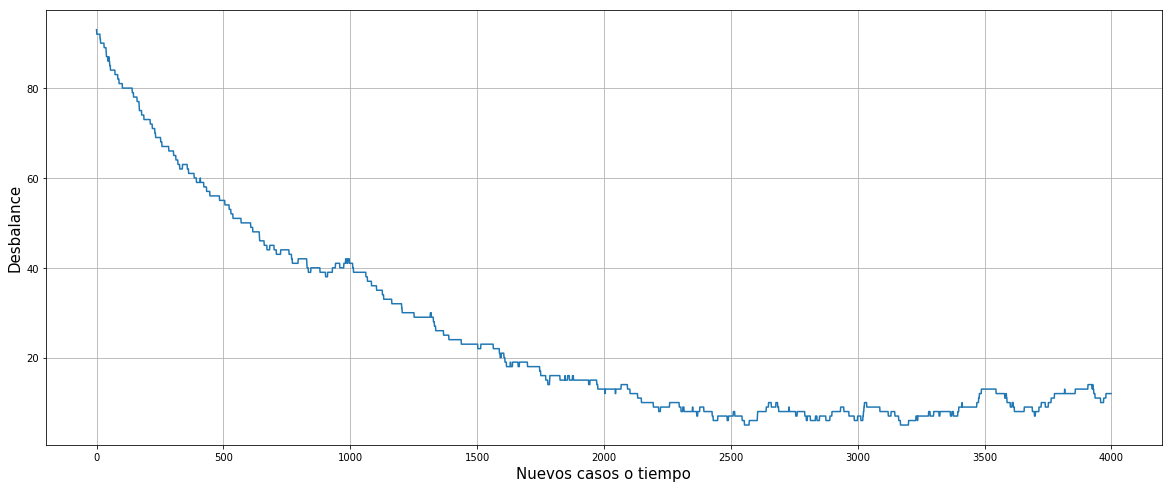

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(Desbalance)
ax.set_xlabel('Nuevos casos o tiempo', fontsize=15)
ax.set_ylabel('Desbalance', fontsize=15)
plt.grid(True)

Quedando para este ejemplo la distribución final de causas por juzgado cómo se ve en el siguiente gráfico.

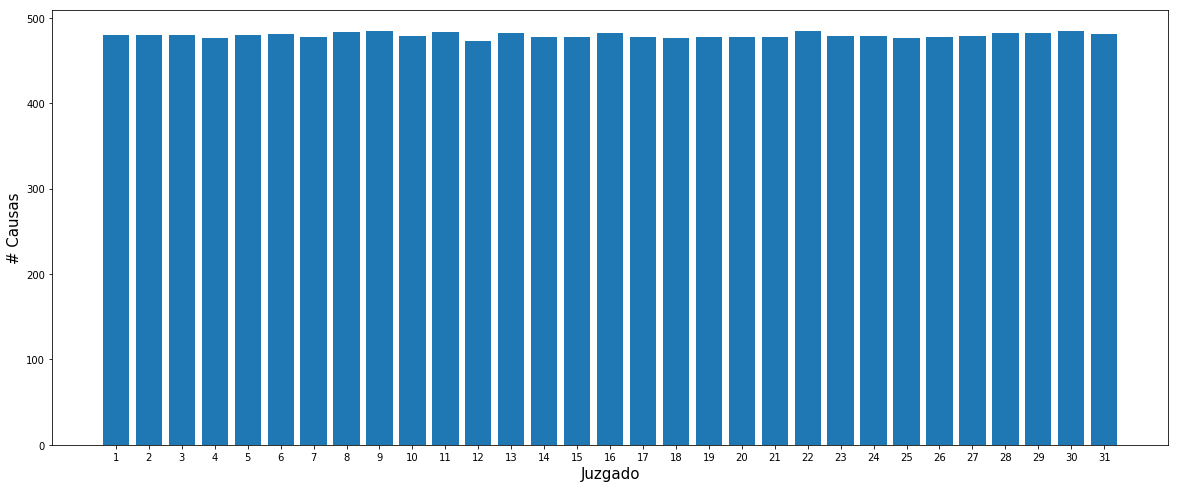

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(31)+1.0
plt.bar(x,causas)
ax.set_xlabel('Juzgado', fontsize=15)
ax.set_ylabel('# Causas', fontsize=15)
x_ticks = ax.set_xticks(x)

# Efecto del parámetro alfa
Con el valor del parámetro alfa de la función que define la probabilidad, se maneja que diferencia de probabilidad va a haber entre juzgados con diferente carga actual de trabajo y con ello a que velocidad se balancea el sistema. Este parámetro se puede fijar agresivo al comienzo para lograr un balanceo más rápido (alfa chico) y luego subirlo un poco en función de qué desbalance máximo se quiera admitir. Vamos a hacer una corrida con dos diferentes alfa para mostrar el efecto en la probabilidad y en la evolución del desbalance en el tiempo.

En los siguientes gráficos se puede observar la distribución inicial de causas y las probabilidades asignadas a cada juzgado para un alfa=20 (gráfico de la izquierda) y un alfa=1 (gráfico de la derecha).

Text(0,0.5,'Probabilidad de asignacion - alfa=1')

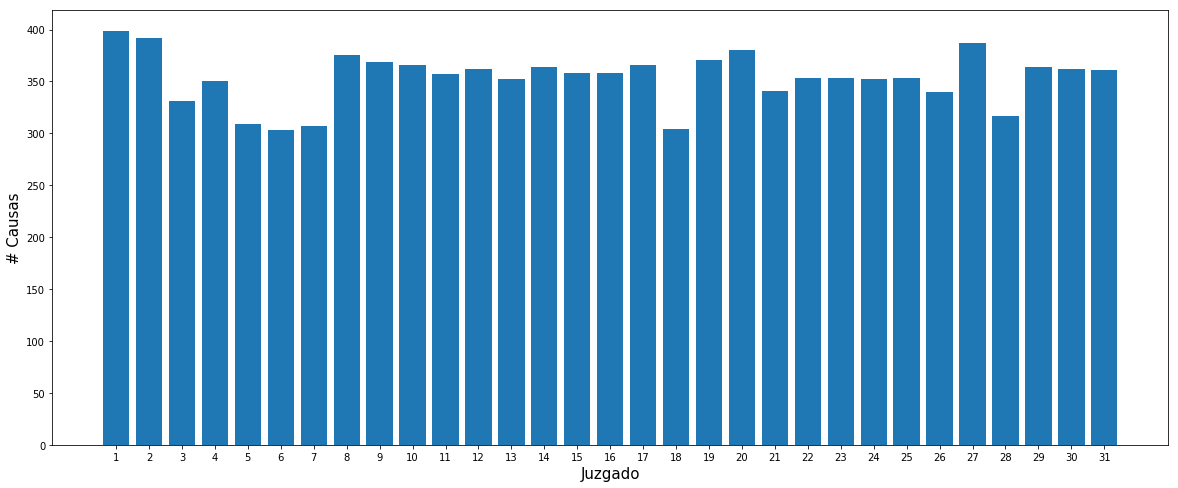

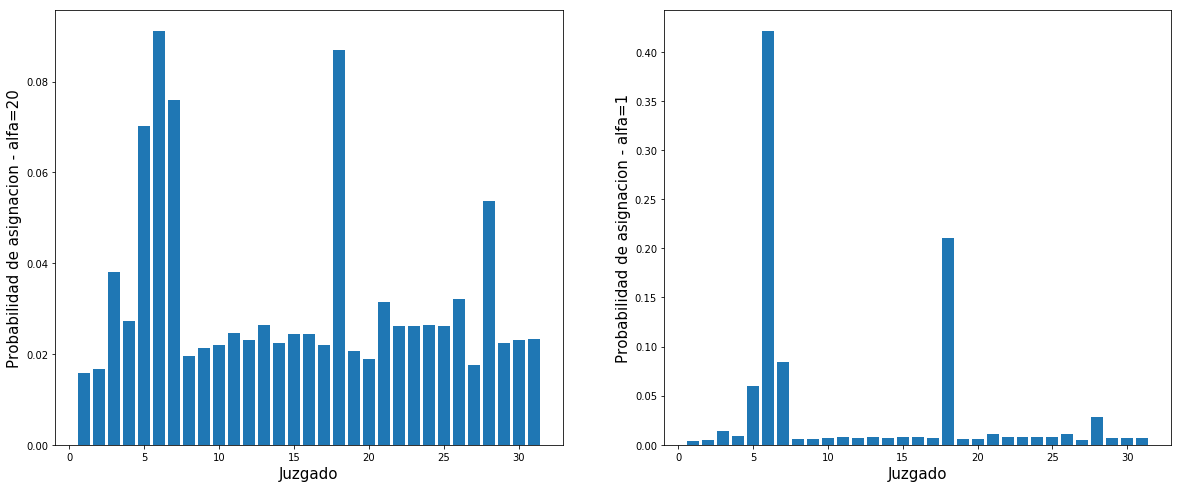

In [8]:
rand = np.random.uniform(0,100,31)
causas = np.array(rand+300,int) 
causas2 = np.array(rand+300,int)

X, Y, P = probabilidad(causas,20)
X2, Y2, P2 = probabilidad(causas2,1)


fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(31)+1.0
plt.bar(x,causas)
ax.set_xlabel('Juzgado', fontsize=15)
ax.set_ylabel('# Causas', fontsize=15)
x_ticks = ax.set_xticks(x)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 8))
ax1.bar(x,P)
ax1.set_xlabel('Juzgado', fontsize=15)
ax1.set_ylabel('Probabilidad de asignacion - alfa=20', fontsize=15)
ax2.bar(x,P2)
ax2.set_xlabel('Juzgado', fontsize=15)
ax2.set_ylabel('Probabilidad de asignacion - alfa=1', fontsize=15)

Ahora vemos cómo evoluciona el desbalance para 4000 nuevas causas. Se puede ver claramente el efecto del parámetro alfa en la velocidad con la que se logra balancear y en que valos de desbalance se genera la meseta (curva roja alfa=20 y curva verde alfa=1)

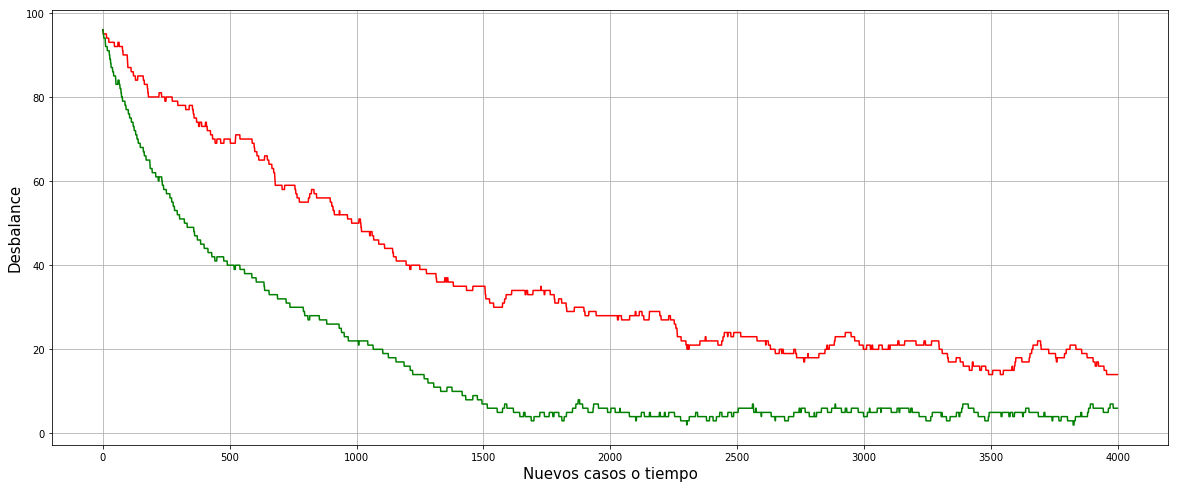

In [9]:
# numero random distribución uniforme
nc = 4000
s = np.random.uniform(0,1,nc)

# Entro con un numero aleatorio U[0,1] y sale con el número de juzgado
Desbalance=[] # Diferencia entre el juzgado que más causas tiene y el que menos
Desbalance2=[]
for ii in range(nc):
    X, Y, P = probabilidad(causas,20)
    JuzSorteado = np.int(griddata(X, Y, s[ii], method='linear'))
    causas[JuzSorteado] +=1
    Desbalance.append(np.max(causas)-np.min(causas))    
    X2, Y2, P2 = probabilidad(causas2,1)    
    JuzSorteado2 = np.int(griddata(X2, Y2, s[ii], method='linear'))    
    causas2[JuzSorteado2] +=1
    Desbalance2.append(np.max(causas2)-np.min(causas2))

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(Desbalance,'r-')
plt.plot(Desbalance2,'g-')
ax.set_xlabel('Nuevos casos o tiempo', fontsize=15)
ax.set_ylabel('Desbalance', fontsize=15)
ax.grid(True)